In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tqdm.notebook import tqdm as tqdm
import itertools
from sklearn.model_selection import train_test_split


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=len(y_train)//10*2)

In [3]:
class DataGenerator(utils.Sequence):
    def __init__(self,data,label,way,batch_size=32,shuffle=False):
        super().__init__()
        self.dataset=np.empty((list(data.shape)+[1]),dtype=np.float32)
        self.dataset[...,0]=data
        self.labels=utils.to_categorical(label,way)
        self.batch_size=batch_size
        self.shuffle=shuffle
    def __len__(self):
        return len(self.dataset)//self.batch_size
    def __getitem__(self,index):
        x=self.dataset[index*self.batch_size:(index+1)*self.batch_size]/255.
        y=self.labels[index*self.batch_size:(index+1)*self.batch_size]
        return x,y
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        if self.shuffle:
            order=np.random.permutation(len(self.dataset))
            self.dataset=self.dataset[order]
            self.labels=self.labels[order]
        for item in (self[i] for i in range(self.__len__())):
            yield item

In [4]:
y_train.shape

(48000,)

In [5]:
way =10
max_epoch = 40
BATCH_SIZE=128
gen_train=DataGenerator(x_train,y_train,way,batch_size=BATCH_SIZE,shuffle=True)
gen_val=DataGenerator(x_val,y_val,way,batch_size=BATCH_SIZE,shuffle=False)
len(gen_train), len(gen_val)

(375, 93)

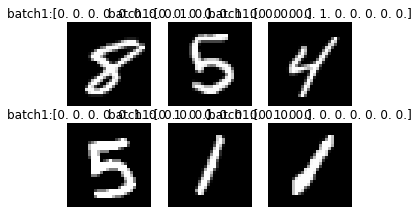

In [6]:
for batch_data,batch_label in gen_train:
    break
gp,ee,n_row,n_col=1,1,2,3
plt.figure(figsize=(n_col*1.7,n_row*1.7))
for ii in range(n_row):
    for jj in range(n_col):
        plt.subplot(n_row,n_col,ee);plt.axis('off');plt.title(f"batch{gp}:{batch_label[ee]}")
        plt.imshow(batch_data[ee,...,0],"gray")
        ee+=1
plt.show()

In [7]:
# Building blocks
class my_cnn2d():
    def __init__(self,k_size=3,in_chs=1,n_filters=32):
        # Determine initialization parameters
        fan_in=k_size*k_size*in_chs
        fan_out=k_size*k_size*n_filters
        #Xavior initialization
        self.w=tf.Variable(tf.random.normal([k_size, k_size, in_chs,n_filters],stddev=np.sqrt(2/(fan_in+fan_out)) ,dtype=tf.float32))
#         self.w=tf.Variable(tf.random.uniform([k_size, k_size, in_chs,n_filters],minval=-np.sqrt(6/(fan_in+fan_out)),maxval=np.sqrt(6/(fan_in+fan_out)),dtype=tf.float32))
#         self.b=tf.Variable(tf.random.normal([n_filters,],stddev=xavior_std,dtype=tf.float32))
        self.b=tf.Variable(tf.zeros([n_filters,],dtype=tf.float32))
        self.strides=[1,1,1,1]
    def __call__(self,x):
        xx=tf.nn.conv2d(x, self.w, strides=self.strides, padding='VALID')+self.b
        xx=tf.keras.activations.relu(xx)
        y=tf.nn.max_pool2d(xx,ksize=2,strides=2,padding="VALID")
        return y
class my_conv_1x1():
    def __init__(self,in_chs=32,n_filters=32):
        # Determine initialization parameters
        k_size=1
        fan_in=k_size*k_size*in_chs
        fan_out=k_size*k_size*n_filters
        #Xavior initialization
        self.w=tf.Variable(tf.random.normal([k_size, k_size, in_chs,n_filters],stddev=np.sqrt(2/(fan_in+fan_out)) ,dtype=tf.float32))
#         self.w=tf.Variable(tf.random.uniform([k_size, k_size, in_chs,n_filters],minval=-np.sqrt(6/(fan_in+fan_out)),maxval=np.sqrt(6/(fan_in+fan_out)),dtype=tf.float32))
#         self.b=tf.Variable(tf.random.normal([n_filters,],stddev=xavior_std,dtype=tf.float32))
        self.b=tf.Variable(tf.zeros([n_filters,],dtype=tf.float32))
        self.strides=[1,1,1,1]
    def __call__(self,x):
        y=tf.nn.conv2d(x, self.w, strides=self.strides, padding='VALID')+self.b
#         y=tf.keras.activations.relu(y)
        return y    
class my_dense():
    def __init__(self,in_chs,out_chs):
        # Determine initialization parameters
        fan_in=in_chs
        fan_out=out_chs
        #Xavior initialization
        self.w=tf.Variable(tf.random.normal([in_chs,out_chs],stddev=np.sqrt(2/(fan_in+fan_out)) ,dtype=tf.float32))
#         self.w=tf.Variable(tf.random.uniform([in_chs,out_chs],minval=-np.sqrt(6/(fan_in+fan_out)),maxval=np.sqrt(6/(fan_in+fan_out)),dtype=tf.float32))
#         self.b=tf.Variable(tf.random.normal([out_chs,],stddev=np.sqrt(2/(fan_in+fan_out)),dtype=tf.float32))
        self.b=tf.Variable(tf.zeros([out_chs,],dtype=tf.float32))
    def __call__(self,x):
        y=tf.matmul(x,self.w)+self.b
        return y

In [8]:
# Model
class cnn_model():
    def __init__(self,way,n_filter=32,drop_rate=0.3):
        self.cnn1=my_cnn2d(3,1,n_filter)
        self.cnn1_1=my_conv_1x1(n_filter,n_filter//2)
        self.cnn2=my_cnn2d(3,n_filter//2,n_filter)
        self.cnn2_1=my_conv_1x1(n_filter,n_filter//2)
        self.cnn3=my_cnn2d(3,n_filter//2,n_filter)
        self.cnn3_1=my_conv_1x1(n_filter,n_filter//2)
#         self.dense=my_dense(1600,way)
        self.dense=my_dense(n_filter//2,way)
        self.drop_rate=drop_rate    
    def __call__(self,x):
        xx=self.cnn1(x)
        xx=self.cnn1_1(xx)
        xx=self.cnn2(xx)
        xx=self.cnn2_1(xx)
        xx=self.cnn3(xx)
        xx=self.cnn3_1(xx)
        # global average pooling
        xx=tf.nn.avg_pool(xx, ksize=[1]+xx.shape[1:-1]+[1], strides=[1, 1, 1, 1], padding='VALID')
        xx=tf.reshape(xx,[xx.shape[0],xx.shape[-1]])
#         xx=tf.reshape(xx,[xx.shape[0],-1])
        xx=tf.nn.dropout(xx, self.drop_rate)
        y=self.dense(xx)
        return tf.keras.activations.softmax(y)
    def trainable_weights(self):
        wt=[]
        for ii in [self.cnn1,self.cnn1_1,self.cnn2,self.cnn2_1,self.cnn3,self.cnn3_1,self.dense]:
            wt=wt+[ii.w]+[ii.b]
        return wt
    def print_shape(self):
        params=0
        for idx,ii in enumerate([self.cnn1,self.cnn1_1,self.cnn2,self.cnn2_1,self.cnn3,self.cnn3_1,self.dense]):
            params+=np.prod(ii.w.shape)+np.prod(ii.b.shape)
            print(f"layer idx: w:{ii.w.shape} + b: {ii.b.shape} = {np.prod(ii.w.shape)+np.prod(ii.b.shape)}")
        print(f"totla {params} parameters")

In [9]:
N_FILTER=32
model=cnn_model(way,N_FILTER)

In [10]:
model.print_shape()

layer idx: w:(3, 3, 1, 32) + b: (32,) = 320
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(16, 10) + b: (10,) = 170
totla 11354 parameters


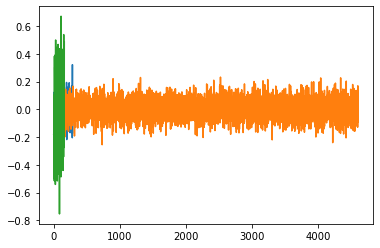

In [11]:
import matplotlib.pyplot as plt
for ii in [model.cnn1,model.cnn2,model.dense]:
    plt.plot(np.reshape(ii.w.numpy(),-1))
#     plt.title(ii.w.numpy().shape)
#     plt.show()

In [12]:
lr=0.001
opt_cnn=keras.optimizers.Adam(lr=lr)
cnn_loss_fn=keras.losses.categorical_crossentropy
lstm_loss_fn=keras.losses.mae
acc_fn = keras.metrics.categorical_accuracy

In [13]:
best_loss=np.Inf

for epoch in range(max_epoch):
    train_sess=tqdm(gen_train)
    train_acc=[]
    for data,label_1_hot in train_sess:
#         label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
        
        with tf.GradientTape() as tape:
            logits=model(data)
            loss1=tf.reduce_mean(cnn_loss_fn(label_1_hot, logits))
        grads=tape.gradient(loss1,model.trainable_weights())
#         break
        opt_cnn.apply_gradients(zip(grads, model.trainable_weights()))
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        train_acc.append(acc)
        train_sess.set_postfix({"CNN loss": loss1.numpy(),"acc":np.mean(train_acc)})
    val_acc=[]
    val_loss=[]
    for data,label_1_hot in gen_val:
#         label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
        logits=model(data)
        loss1=tf.reduce_mean(cnn_loss_fn(label_1_hot, logits)).numpy()
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        val_loss.append(loss1)
        val_acc.append(acc)
    print(f"CNN val: loss: {np.mean(val_loss):.08f},acc: {np.mean(val_acc):.02f},lr: {lr}")
    if best_loss<np.mean(val_loss):
        break
    else:
        best_loss=np.mean(val_loss)
#     break
#     lr=lr*0.1
#     opt_cnn=keras.optimizers.Adam(lr=lr)


CNN val: loss: 0.34499183,acc: 0.90,lr: 0.001



CNN val: loss: 0.22592391,acc: 0.93,lr: 0.001



CNN val: loss: 0.17126165,acc: 0.95,lr: 0.001



CNN val: loss: 0.15683946,acc: 0.96,lr: 0.001



CNN val: loss: 0.14577489,acc: 0.96,lr: 0.001



CNN val: loss: 0.14103894,acc: 0.96,lr: 0.001



CNN val: loss: 0.11237855,acc: 0.97,lr: 0.001



CNN val: loss: 0.11896275,acc: 0.97,lr: 0.001
